The main purpose of this study is correctly predicting the countries/cities air pollution change with the machine learning algorithms such as logistic regression, support vector machine, random forest decision tree, k-nearest neighbor.

In [1]:
# General Libraries for Data Analysis and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium


# Classification 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#Standardization
from sklearn.preprocessing import StandardScaler

# Evaluation Metrics 
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score,roc_curve, auc

# Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import RepeatedKFold

from warnings import filterwarnings
filterwarnings('ignore')

## Descriptive Statistics

In [2]:
# load data set
data = pd.read_csv("covid_data.csv")
data.head()

,Country,City,Country_Population,Total_Day_Lockdown,Avg_Pollution_2020,Avg_Pollution_2019,Change,Development,Total_Case,Total_Death,Latitude,Longitude
0,United Arab Emirates,Dubai,9890400,23,86.0,95,1,1,22627,214,23.424076,53.847818
1,Argentina,Buenos Aires,45195777,60,35.9,35,0,0,7792,363,-38.416097,-63.616672
2,Austria,Vienna,9006400,29,44.0,50,1,1,16140,628,47.516231,14.550072
3,Australia,Melbourne,25499881,56,31.0,28,0,1,7036,98,-25.274398,133.775136
4,Bangladesh,Dhaka,25499881,31,175.0,210,1,0,7036,98,23.684994,90.356331


In [3]:
data.shape

(47, 12)

There are 47 observation and 12 attributes in the dataset.

In [4]:
data.isnull().values.any()

False

There is no mising value in the dataset.

In [5]:
# it is float, it may caouse problems, so it turned into int.
data["Avg_Pollution_2020"] = data["Avg_Pollution_2020"].astype("int64")

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 12 columns):
Country               47 non-null object
City                  47 non-null object
Country_Population    47 non-null int64
Total_Day_Lockdown    47 non-null int64
Avg_Pollution_2020    47 non-null int64
Avg_Pollution_2019    47 non-null int64
Change                47 non-null int64
Development           47 non-null int64
Total_Case            47 non-null int64
Total_Death           47 non-null int64
Latitude              47 non-null float64
Longitude             47 non-null float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.5+ KB


- There are two categorical variables in the dataset. Their datatypes are represented as 'object'. (Country and City attributes)

- There are 10 numnerical attributes their data types are reprepsented as 'int' or 'float'. 

In [7]:
pd.set_option('float_format', '{:f}'.format) #used for the changing format for float type data.
data.describe()

,Country_Population,Total_Day_Lockdown,Avg_Pollution_2020,Avg_Pollution_2019,Change,Development,Total_Case,Total_Death,Latitude,Longitude
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,101724795.595745,41.276596,61.021277,66.595745,0.680851,0.617021,82515.191489,5941.148936,30.557918,21.323863
std,286095427.055912,16.553867,37.252656,45.319954,0.471186,0.491369,220366.267322,15064.538718,27.445875,60.137554
min,2722291.000000,7.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-40.900557,-95.712891
25%,6369824.500000,29.500000,38.000000,39.000000,0.000000,0.000000,4897.500000,102.500000,22.008880,-0.888174
50%,19116209.000000,43.000000,44.000000,53.000000,1.000000,1.000000,16140.000000,497.000000,39.399872,15.472962
75%,55672356.000000,55.500000,82.500000,75.000000,1.000000,1.000000,69516.500000,2780.000000,49.243259,50.664792
max,1439323774.000000,77.000000,175.000000,217.000000,1.000000,1.000000,1467884.000000,88754.000000,61.924110,174.885971


- All variables have different mean and standard deviation value, each of the attributes have dfferent scale.

- In average this year PM2.5 level is lower than the last year. 
- 61% of the countries are developed according to their Gdp per capita.
- From the mean value of Change attribute, it can be said that 68% of the cities PM2.5 level has been decreased.


For the rest of the analysis, since standardization will provide better result, before the apply any algorithm the data should be standardized.

#### Worldwide Cases and Deaths 


- In this study one major cities of each 47 countries is taken, their PM2.5 levels are compared with 2020 and 2019 in the same period, but number of cases and number of death from coronavirus could not be found as citywise, becaue of that countrywise values are used in this study. 

- In the belove map, countries (which was selected in this study),  total number of confirmed cases and total number of deaths can be seen (as of 17th May).

In [8]:
# World Map
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=4, zoom_start=1)

for i in range(0, len(data)):
    folium.Circle(
        location=[data.iloc[i]['Latitude'], data.iloc[i]['Longitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(data.iloc[i]['Country'])+
                    
                    '<li><bold>Confirmed : '+str(data.iloc[i]['Total_Case'])+
                    '<li><bold>Deaths : '+str(data.iloc[i]['Total_Death']),
        radius=int(data.iloc[i]['Total_Case'])**0.5).add_to(m)
m

## Descriptive Statistics of Target Variable

In [9]:
data["Change"].describe()

count   47.000000
mean     0.680851
std      0.471186
min      0.000000
25%      0.000000
50%      1.000000
75%      1.000000
max      1.000000
Name: Change, dtype: float64

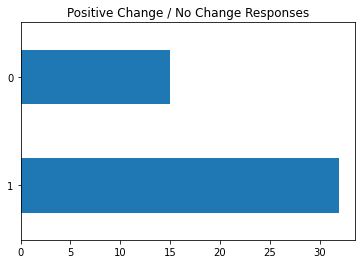

In [10]:
plt.title ("Positive Change / No Change Responses")
data["Change"].value_counts().plot.barh();

In this graph it can be seen that total number of 1's is much larger than total number  0's. Nearly 68% of the cities has been affected positively and 32% of the cities has been faced with negative change or stay same in terms of PM2.5 levels.

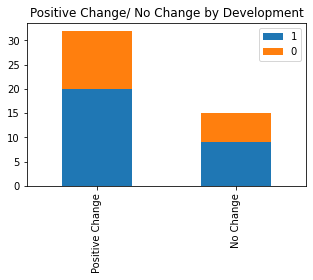

In [11]:
positive_change = data[data.Change == 1]['Development'].value_counts()
no_change = data[data.Change == 0]['Development'].value_counts()
df_change = pd.DataFrame([positive_change , no_change])
df_change.index = ['Positive Change' , 'No Change']
df_change.plot(kind='bar',stacked=True, figsize=(5,3), title="Positive Change/ No Change by Development");

In the graph above, developed countries represented with color "blue". It can be said that cities that has been change positively are belong to the developed countries. In "no change", number of developed and developing countries seem equal according to the graph. 

### Correlation with Change Attributes

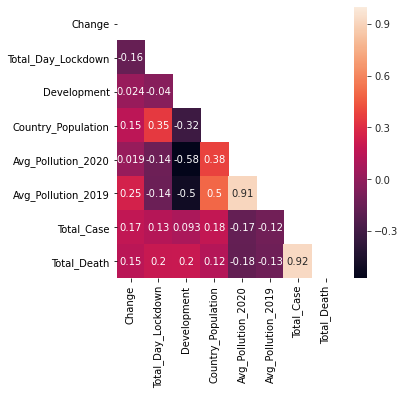

In [12]:
used_columns_data= data[["Change", "Total_Day_Lockdown", "Development",
              "Country_Population",  "Avg_Pollution_2020",
              "Avg_Pollution_2019","Total_Case","Total_Death"]] # some of the columns will not be used in this study, they used only for visualization (Longitude, Latitude)
ix = used_columns_data.corr().sort_values('Change', ascending=False).index
df_sorted_by_correlation = used_columns_data.loc[:, ix]


corr = used_columns_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(5,5))
with sns.axes_style("white"):
    # display a correlation heatmap
    ax = sns.heatmap(corr, mask=mask, annot=True)

- All varaibles in the dataset has weak correlation with the response variable Change. 
- Total Case and Total Deaths have strong correlation with each other.
- Avg_Pollution_2020 and Avg_Pollution_2019 has moderate correlation with Country Population.
- Also development is negatively correlated with Avg_Pollution_2020 and Avg_Pollution_2019, when development increase air pollution is decreased. 

In [13]:
## Outlier 
def outliers(numeric_columns):
    for columns in numeric_columns:
        quantiles=data[columns].quantile(q=[0.25,0.50,0.75]).values
        q1=quantiles[0]
        q2=quantiles[1]
        q3=quantiles[2]
        iqr=q3-q1
        outliers=data[(data[columns] < q1-1.5*iqr ) | (data[columns] >  q3+ 1.5*iqr)][columns]
        print("number of outliers in", columns, ":", (len(outliers))) 

In [14]:
numeric_columns=[ "Total_Day_Lockdown", "Development","Country_Population", "Change", 
                 "Avg_Pollution_2020", "Avg_Pollution_2019","Total_Case","Total_Death"]
outliers(numeric_columns)

number of outliers in Total_Day_Lockdown : 0
number of outliers in Development : 0
number of outliers in Country_Population : 6
number of outliers in Change : 0
number of outliers in Avg_Pollution_2020 : 2
number of outliers in Avg_Pollution_2019 : 4
number of outliers in Total_Case : 7
number of outliers in Total_Death : 8


- There are some outliers in the Country_Population, Avg_Pollution_2020, Avg_Pollution_2019, Total_Case, Total_Death. Since dataset contains limited number of observation outliers, analysis will be done with this dataset with the outliers. 

In [15]:
# Split dataset to X and y sets. X is for independent variables and y for target varaibles.
# The purpse is classifying the change in the air pollution, so 'Change' variable is target variable.
# Note that 'Country', name of country, 'City' name of city, 'Latitude' and 'Longitude' does not provide important information for the classification.

def split_data(data, target_variable):
    data.drop(columns=['Country','City','Latitude','Longitude'], inplace=True)
    y = data[target_variable]

    X = data.drop([target_variable], axis=1)
    X.head()
    
    return X,y

In [16]:
X, y = split_data(data, "Change")

## Standardization

When independent variables in training data are measured in different units, it is important to standardize variables before applying algorithms because one variable may dominate all the others. Since in the dataset all variables are in different scale, before applying any algorithm to the data, explanatory variables are standardized. 

In [18]:
X = StandardScaler().fit_transform(X)
#X = pd.DataFrame(X, columns = ['Country_Population','Total_Day_Lockdown','Average_AirPollution','Last_year_avg_pollution','Gdp_per_capita','Total_Case','Total_Death'])
X = pd.DataFrame(X, columns = ['Country_Population','Total_Day_Lockdown','Avg_Pollution_2020','Avg_Pollution_2019',"Development","Total_Case","Total_Death"])


## Train Test Split

In all analysis data set is divided into training data and test data. 30% of the data is used for testing, remaining 70% is used for training. Training set contains 35 observations and test set contains 15 observations.

In [19]:
X_training, X_test, y_training, y_test = train_test_split(X, y, 
                                                    test_size = 0.30, 
                                                    random_state = 42)

In [20]:
X_training

,Country_Population,Total_Day_Lockdown,Avg_Pollution_2020,Avg_Pollution_2019,Development,Total_Case,Total_Death
13,-0.063387,0.471606,-0.651792,-0.280934,0.787839,0.421265,0.132376
17,-0.194216,0.960101,-0.570390,-0.459365,0.787839,0.682699,1.456636
44,-0.061426,-1.604500,0.080824,0.120536,-1.269296,0.300683,-0.123807
15,-0.204475,0.715854,0.270762,0.031320,-1.269296,-0.347206,-0.362276
9,4.725905,2.181340,1.193316,1.614896,-1.269296,0.007013,-0.087440
16,-0.297071,-1.543438,-0.380452,-0.191719,-1.269296,-0.228211,-0.218282
29,-0.349788,0.105234,-0.461854,-0.191719,0.787839,-0.371457,-0.394953
32,-0.340253,-0.505385,-0.950265,-0.682404,0.787839,-0.340895,-0.383077
45,-0.204890,-0.139013,-0.516122,-0.526277,-1.269296,-0.296580,-0.365295
0,-0.324462,-1.116004,0.677771,0.633525,0.787839,-0.274705,-0.384284


## Models


- In this section logistic regression, support vector classifier, random forest classifier and k-nearest neighbor classifiers will be used. Their hyperparameters will be tuned, after tuning general performance of the model will be calculated with repeated 5-Fold cross validation.


### Hyperparameter Optimization


A hyperparameter is external to the model and the value of it cannot be estimated from data. It affects the model performance and because of that hyperparameter tuning is important for all algorithms. In this study, for each of the algorithms best hyperparameters are found with grid search cross validation. Grid-searching is a method that searching for best combination of hyperparameters. In Scikitlearn library in python, there is a method which name is GridSearchCV() (Scikitlearn, 2019). This method allows to use cross validation and it find best hyperparameters for the selected model. For this study, hypothetical set for each the hyperparameter are defined first, and best combination of hyperparameters are selected by GridSearchCV() method with repeated 5-fold cross validation on training dataset, this best hyperparameters are used for the rest of analysis.

 



In [21]:
def find_best_parameters(estimator, parameters):
    
    """" Find the best parameter setting using the grid search cross validation. 
    Use the repeated 5fold crossvalidation.
    """
    
    cv_method = RepeatedKFold(n_splits=5, n_repeats=10, random_state=7)

    gs_LR = GridSearchCV(estimator=estimator, 
                     param_grid=parameters, 
                     cv=cv_method,
                    n_jobs=-1, 
                    verbose=2)
    # n_jobs = -1 means using all processors.
    # verbose used for controlling the verbosity: the higher, the more messages.)
    
    gs_LR.fit(X_training, y_training);
    
    return gs_LR.best_params_

In [23]:
def model_fit_predict(classifier):
    
    """" Fit the model with best parameters settings (tuned) and predict the test data.
    Return predicted test data.
    """
    
    tuned_model = classifier
    tuned_model.fit(X_training, y_training)
    y_pred_test = tuned_model.predict(X_test)
    
    return y_pred_test


In [24]:
def model_evaluate(y_pred_test):
    
    """" Evaluate the models performance using the test data. 
    Use confusion matrix, accuracy score and F1-score as performance metrics. 
    """
    
    
    print("confusion Matrix: ", confusion_matrix(y_test, y_pred_test), 
          "\nAccuracy score: ", "{:.2f}".format(accuracy_score(y_pred_test, y_test)), 
          "\nF1-score: ", "{:.2f}".format(f1_score(y_pred_test, y_test)))
    

In [27]:
def plot_roc_curve(y_pred_test, title):
    
    """" Plot the Receiver Operating Characteristic Curve. """

    fpr, tpr, threshold = roc_curve(y_test, y_pred_test)
    roc_auc = auc(fpr, tpr)

    plt.title(title)
    plt.plot(fpr, tpr, 'b', label ='AUC = %0.2f' % roc_auc)
    plt.legend(loc ='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [29]:
def model_general_performance(tuned_model, title):
    cv_method = RepeatedKFold(n_splits=5, n_repeats=10, random_state=7)
    f1_score = cross_val_score(tuned_model, X=X, y=y, cv=cv_method, scoring='f1')
    print("F1 Score of ", title, ": %0.2f (+/- %0.2f)" % (f1_score.mean(), f1_score.std()))

In [60]:
def general_f1_score(tuned_model):
    cv_method = RepeatedKFold(n_splits=5, n_repeats=10, random_state=7)
    f1_score = cross_val_score(tuned_model, X=X, y=y, cv=cv_method, scoring='f1')
    return f1_score

## 1. Logistic Regression


Logistic regression is a type of classification algorithm. Logistic regression turns linear predictions into probabilities by using the logistic function. Logistic regression can be used for binary classification. It takes solver as parameter to solve the optimization problem. In Scikitlearn, for small dataset it is suggested that using solver as "liblinear" (Scikitlearn, 2019). It uses the penalty to specify the norm used in the penalization. The penalty parameters of logistic regression could be l1 penalization, l2 penalization or elasticnet. Different types of penalization terms are tried in this study.

###  Finding The Best Parameters (Hyperparameter Tuning)

In [22]:
logistic_regression = LogisticRegression(solver = "liblinear", random_state=3)
parameters_logistic_regression = { "penalty":["l1","l2","elasticnet"] }

best_parameters_logistic_regression = find_best_parameters(logistic_regression, parameters_logistic_regression)
best_parameters_logistic_regression

Fitting 50 folds for each of 3 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.3s finished


{'penalty': 'l2'}

Best parameter for penalty = l2

### Fit & Predict

In [54]:
# Fit and predict the model (predictions are made on test data)
tuned_model_logistic_regression =  LogisticRegression(solver="liblinear", penalty="l2", random_state=3)

y_pred_test = model_fit_predict(tuned_model_logistic_regression)

### Evaluate The Performance

In [26]:
# Evaluate the model on test data
model_evaluate(y_pred_test)

confusion Matrix:  [[3 1]
 [3 8]] 
Accuracy score:  0.73 
F1-score:  0.80


- Hyperparameter optimization is made with the method, which is mentioned above, and best penalty parameter is found as l2 penalization. The model is fitted using this hyperparameter on the training data and predictions are made on the test data. The accuracy score, f1 score, confusion matrix and roc curve are obtained.

- 8 of the actual positive instances are correctly classified as positive, 3 of the actual negative instances are correctly classified as negative. 3 of the actual positive instances are incorrectly classified as negative and 1 of the actual negative instances is incorrectly classified as positive. Total number of false negatives is higher than total number of false positives. The model tends to make Type II error. 

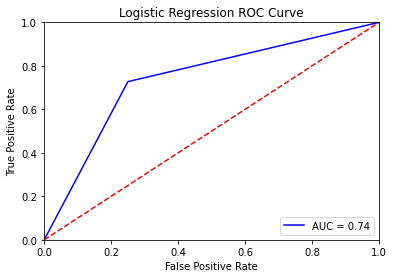

In [28]:
# Plot ROC curve
plot_roc_curve(y_pred_test, 'Logistic Regression ROC Curve')

Logistic regression tuned model have nearly 75% true positive rate (Sensitivity) and 25% false positive rate (1-Specificity), area under curve is calculated as 0.74.

### General Performance- F1 Score

- F1 score is selected as general perofrmance evaluation metric.
- Due to the limited number of observations and imbalanced distribution of classes, accuracy score may not be meaningful for evaluating the model.

In [30]:
# General performance of model
general_score_logistic_regression = model_general_performance(tuned_model_logistic_regression, "Logistic Regression")

F1 Score of  Logistic Regression : 0.79 (+/- 0.13)


The model has average 0.79 f1 score, with confidence interval CI = [0.66, 0.92]

## 2. Support Vector Classifier

- C is regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

- Gamma is kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’

- Kernel specifies the kernel type to be used in the algorithm.

Different C, gamma and kernel values are tried to find best parameter with repeated 5-fold cross validation on training data.

### Hyperparameter Tuning

In [31]:
svc = SVC(random_state= 5)
parameters_svc = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','linear', 'poly']} 

best_parameters_svc = find_best_parameters(svc, parameters_svc)

Fitting 50 folds for each of 75 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed:    4.3s finished


In [32]:
best_parameters_svc

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

Hyperparameter optimization is made and the best parameters are selected as C=1000, γ = 0.01 and kernel function is radial basis function. The model is fitted using these hyperparameters on the training data and predictions are made on the test data.

### Fit & Predict 

In [33]:
# Fit and predict model (predictions are made on test data)
tuned_model_svc = SVC(C=1000, gamma=0.01 , kernel='rbf', random_state=5)

y_pred_test = model_fit_predict(tuned_model_svc)

### Evaluate The Performance 

In [34]:
# Evaluate the perofrmance of model on test data
model_evaluate(y_pred_test)

confusion Matrix:  [[ 3  1]
 [ 1 10]] 
Accuracy score:  0.87 
F1-score:  0.91


10 of the actual positive instances are correctly classified as positive, 3 of the instances are correctly classified as negative. 1 of the instances is incorrectly classified as positive and 1 of the instances is incorrectly classified as negative. 

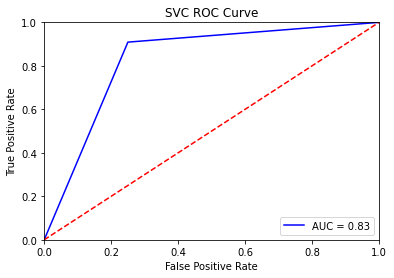

In [35]:
# Plot ROC curve
plot_roc_curve(y_pred_test, 'SVC ROC Curve')

True positive rate is higher than 0.80 and false positive rate is lower than 0.2, are under curve is calculated as 0.83

### General Performance -  F1 Score

In [36]:
# General performance of the model
general_score_svc = model_general_performance(tuned_model_svc, "Support Vector Classifier")

F1 Score of  Support Vector Classifier : 0.92 (+/- 0.07)


The model has average 0.92 f1 score on general, with confidence interval CI = [0.85, 0.99].  This confidence interval is tighter when compared to the logistic regression model.

## 3. Random Forest

Random forest classifier creates a set of decision trees from randomly selected subset of training set. It is recommended to use bootstrap samples. In sklearn, RandomForestClassifier() provides to use bootstrap samples when building trees. In random forest classifier, tuned parameters is selected as max_depth of the tree, max_features: the number of features to consider when looking for the best split, n_estimators: the number of trees in the forest, min_samples_split: the minimum number of samples required to split an internal node. Their values are selected arbitrarily.

### Hyperparameter Tuning

In [37]:
random_forest = RandomForestClassifier(bootstrap=True,random_state=5)
parameters_random_forest = {"max_depth": [2,5,8,10],
            "criterion" : ["gini", "entropy"],
            "n_estimators": [10,500,1000],
            "min_samples_split": [2,5,10]}

best_parameters_rf = find_best_parameters(random_forest, parameters_random_forest)

Fitting 50 folds for each of 72 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 475 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 894 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1395 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2099 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2863 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  4.0min finished


In [38]:
best_parameters_rf

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_split': 10,
 'n_estimators': 1000}

Hyperparameters are optimized and the best parameters were selected as “1000” estimator, “entropy” criterion, “5” maximum depth, “10” minimum sample splits. The model is fitted using this hyperparameters on the training data and predictions are made on the test data. 

### Fit & Predict

In [39]:
# Fit and predict the model (predictions are made on test data)
tuned_model_random_forest = RandomForestClassifier(max_depth=5 , criterion='entropy', 
                                                   min_samples_split=10, n_estimators=1000, random_state=5)
y_pred_test = model_fit_predict(tuned_model_random_forest)

### Evaluate The Performance

In [40]:
# Evaluate the perofrmance of model on test data
model_evaluate(y_pred_test)

confusion Matrix:  [[ 1  3]
 [ 1 10]] 
Accuracy score:  0.73 
F1-score:  0.83


10 of the actual positive instances are correctly classified as positive, 1 of the instances is correctly classified as negative. 3 of the instances are incorrectly classified as positive and 1 of the instances are incorrectly classified as negative. The number of false positives is higher than the number of false negatives, this model tends to make Type I error. 

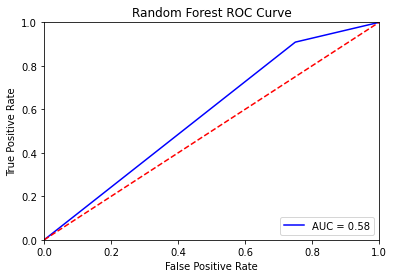

In [41]:
# Plot ROC curve
plot_roc_curve(y_pred_test, 'Random Forest ROC Curve')

### General Performance- F1 Score

In [42]:
# General perofrmance of the model
general_score_random_forest = model_general_performance(tuned_model_random_forest, "Random Forest")

F1 Score of  Random Forest : 0.76 (+/- 0.13)


- The model has average 0.74 F1 score, with confidence interval CI = [0.61, 0.87].  

## 4. k-Nearest Neighbor Classifier

K nearest neighbors is a simple algorithm that classifies based on a distance function. In this study, different k number of neighbor values and different distance functions were tried for the hyperparameter tuning. Number of neighbors considered 1 to 8 and  p(distance)  values of 1 (Manhattan), 2 (Euclidean), and 5 (Minkowski) are tried to find best parameter with repeated 5-fold cross validation on training data.

### Hyperparameter Tuning

In [43]:
kNN = KNeighborsClassifier()

parameters_kNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8], 
              'p': [1, 2, 5]}
best_parameters_kNN = find_best_parameters(kNN, parameters_kNN)

Fitting 50 folds for each of 24 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    1.4s finished


In [44]:
best_parameters_kNN

{'n_neighbors': 7, 'p': 2}

### Fit & Predict

In [45]:
# Fit and predict the model (predictions are made on test data)
tuned_model_kNN = KNeighborsClassifier(n_neighbors=7, p=2)
y_pred_test = model_fit_predict(tuned_model_kNN)

- Hyperparameters are optimized and the best parameters are selected as k=7, p = 2. The model is fitted using this hyperparameter on the training data and predictions are made on the test. 

### Evaluate The Performance

In [46]:
# Evaluate the perofrmance of model on test data
model_evaluate(y_pred_test)

confusion Matrix:  [[1 3]
 [3 8]] 
Accuracy score:  0.60 
F1-score:  0.73


- 8 of the actual positive instances are correctly classified as positive, 1 of the instances is correctly classified as negative. 3 of the instances are incorrectly classified as positive and 3 of the instances are incorrectly classified as negative. This model tends make both Type II and Type I error.

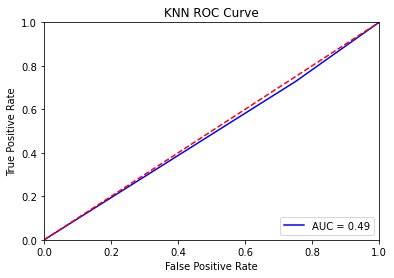

In [47]:
# Plot ROC curve
plot_roc_curve(y_pred_test, 'KNN ROC Curve')

- This model has nearly 75% false positive rate. It has the lowest true positive rate when compared to the other models. Also, area under curve is calculated as 0.49. It can be said that k-nearest neighbor algorithm does not perform well.

### General Performance-F1 Score

In [50]:
# General perofrmance of the model
general_score_kNN = model_general_performance(tuned_model_kNN, "k-Nearest Neighbor Classifier")

F1 Score of  k-Nearest Neighbor Classifier : 0.73 (+/- 0.14)


- In general, the model has average 0.73 f1 score, with confidence interval CI = [0.59, 0.87].  

# Final Evaluation

In [61]:
# General F1 score and confidence intervals of the models

print("-"*28)
print("Logistic Regression:\n F1 Score:", general_f1_score(tuned_model_logistic_regression).mean(), "+/-",
      general_f1_score(tuned_model_logistic_regression).std(),"\n")
print("-"*28)
print("Support Vector Classifier:\n F1 Score:", general_f1_score(tuned_model_svc).mean(), "+/-", 
      general_f1_score(tuned_model_svc).std(),"\n")
print("-"*28)
print("Random Forest:\n F1 Score:", general_f1_score(tuned_model_random_forest).mean(), "+/-", 
      general_f1_score(tuned_model_random_forest).std(),"\n")
print("-"*28)
print("K Nearest Neighbors:\n F1 Score:", general_f1_score(tuned_model_kNN).mean(), "+/-",
      general_f1_score(tuned_model_kNN).std(),"\n")

----------------------------
Logistic Regression:
 F1 Score: 0.7882076877370995 +/- 0.13137486481101732 

----------------------------
Support Vector Classifier:
 F1 Score: 0.9221134094663506 +/- 0.07379007242079721 

----------------------------
Random Forest:
 F1 Score: 0.7610149381062692 +/- 0.129070372721031 

----------------------------
K Nearest Neighbors:
 F1 Score: 0.7303605348899467 +/- 0.1385073459820168 



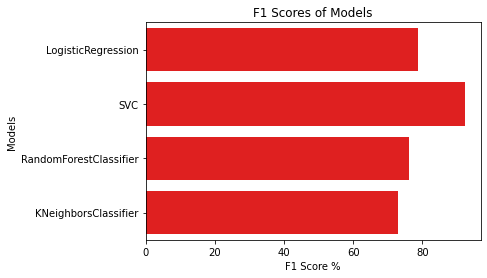

In [56]:
# Bar chart of the F1 score of models

models = [ tuned_model_logistic_regression,
          tuned_model_svc,
          tuned_model_random_forest,
          tuned_model_kNN]

result = []

results = pd.DataFrame(columns= ["Models","F1 Score"])
cv_method = RepeatedKFold(n_splits=5, n_repeats=10, random_state=7)

for model in models:
    names = model.__class__.__name__
    f1_score = cross_val_score(model, X=X, y=y, cv=cv_method, scoring='f1').mean()
    result = pd.DataFrame([[names, f1_score*100]], columns= ["Models","F1 Score"])
    results = results.append(result)
    
    
sns.barplot(x= 'F1 Score', y = 'Models', data=results, color="r")
plt.xlabel('F1 Score %')
plt.title('F1 Scores of Models');    

It can be said that support vector machine performs better than others, it has higher f1 score and tighter confidence interval. Support vector machine has a better performance in overall. Logistic regression has the second-best performance. K-nearest neighbor and random forest have nearly same performance. The reason of why SVC has better performance might be, support vector machines perform better with small dataset with fewer outliers. Random forest, logistic regression and k nearest neighbor may require more data.

## References 


Banerjee, P. (2020, March 13). KNN Classifier Tutorial in Python. Kaggle. https://www.kaggle.com/prashant111/knn-classifier-tutorial

Cross Validation (2019) Retrieved May 31,2020, from https://scikit-learn.org/stable/modules/cross_validation.html


Grid Search Cross Validation. (2019). Retrieved May 31, 2020, from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Logistic Regression (2019) Retrieved May 31, 2020, from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Kumar, D. (2020, May 28). Covid-19 Analysis, Visualization & Comparisons. Kaggle. https://www.kaggle.com/imdevskp/covid-19-analysis-visualization-comparisons

Model Evaluation (2019) Retrieved May 31, 2020, from https://scikit-learn.org/stable/modules/model_evaluation.html

Model Validation in Python. (2018, June 19). Retrieved May 2, 2020, from https://www.datavedas.com/model-validation-in-python/

Random Forest Classifier (2019) Retrieved May 31, 2020, from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Receiver Operating Characteristic (ROC) (2019) Retrived May 31, 2020, from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

SVM Hyperparameter Tuning Using GridSearcCV. (n.d.). Retrieved May 31, 2020, from https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/